# Two component signals: constant amplitude and constant frequency

### Produces Figures 16 and 17

We consider simple linear combination of sine waves. We vary (1) the length of the signal, (2) the frequency ratio between the two components, and (3) the sample rate. 

We aim to replicate:
- Daetig and Schlurrmann (2004), Figures 8 and 9.

Reference
- Daetig, M. and Schlurrmann, T. (2004). Performance and limitations of the Hilbert-Huang transformation (HHT) with an application to irregular water waves. Ocean Engineering, 31:1783–1834.


**Note.** Rilling and Flandrin (2008) use the opposite convention as Daetig and Schlurmann (2004). Daetig and Schlurmann (2004) have a low frequency and the high frequency is multiples of it (from 1 to 15). Rilling and Flandrin (2008) have a high frequency and the low frequency is ratios of it (0.01 to 1.0). This results in the order of the components being reversed. Keep this in mind when looking at this notebook and $\texttt{5_emd_replicate_rilling.ipynb}$.

### Import Libraries

In [1]:
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import numpy as np
import time
import PyEMD

from scipy.io import loadmat
from scipy.signal import hilbert
from scipy import fftpack

### Set up and run simulation

In [2]:
""" 
===============================================================================================
                                    PARAMETER DEFINITIONS
===============================================================================================
"""
np.random.seed(1)                          # set seed for reproducibility

# FREQUENCIES OF COMPONENTS --------------------------------------------------------------
n_freq_steps = 100                         # number of frequency increments

min_r = np.log(1.)/np.log(10)              # minimum ratio 
max_r = np.log(15.)/np.log(10)             # maximum ratio
ratios = np.logspace(start=min_r,          # ratio of riding wave to carrier wave
                     stop=max_r, 
                     num=n_freq_steps)
f_1 = 8                                    # frequency of carrier wave, scalar (8 Hz theta)
f_2 = f_1 * ratios                         # frequency of riding wave, vector
F = []                                     # List to contain each increment
for k in range(n_freq_steps):              # build the list
    F.append([f_1, np.round(f_2[k], 2)])

# SAMPLE RATES ----------------------------------------------------------------------------
n_sample_rates = 100                           # number of increments
lowest_rate = np.log(0.1*f_1)/np.log(10)       # start at 2x the carrier wave
highest_rate = np.log(20*F[-1][1])/np.log(10)  # end at 20x the fastest riding wave
FS = np.logspace(start=lowest_rate,            # build vector of sample rates 
                 stop=highest_rate,
                 num=n_sample_rates)

# SIGNAL LENGTHS --------------------------------------------------------------------------
n_lengths = 4 #40                          # number of signal lengths (defines increment)
cycle_length = 1/f_1                       # one cycle of slowest component
max_cycles = 30                            # max number of cycles
max_length = max_cycles * cycle_length     # max length in seconds
sig_lengths = np.linspace(cycle_length,    # array of signal lengths
                          max_length, 
                          n_lengths)

# COMPONENT PARAMETERS --------------------------------------------------------------------
max_amp = 1000.                            # maximum amplitude of signal component
nF = len(F[0])                             # number of frequency components
p = np.random.uniform(low=0.0,             # phase offsets for components
                      high=2*np.pi,
                      size=nF)

# STORE RESULTS ---------------------------------------------------------------------------
# initialize matrix to store correlations
C_all = np.empty(shape=(n_freq_steps, n_sample_rates, n_lengths, nF, nF))     
IF_all = np.empty(shape=(n_freq_steps, n_sample_rates, n_lengths, nF)) 
IA_all = np.empty(shape=(n_freq_steps, n_sample_rates, n_lengths, nF)) 
IF_nb_all = np.empty(shape=(n_freq_steps, n_sample_rates, n_lengths, nF)) 
IA_nb_all = np.empty(shape=(n_freq_steps, n_sample_rates, n_lengths, nF)) 

inst_freq_all = np.empty(shape=(n_freq_steps, n_sample_rates, n_lengths, nF))
inst_amp_all = np.empty(shape=(n_freq_steps, n_sample_rates, n_lengths, nF))

n_IMFs = np.empty(shape=(n_freq_steps, n_sample_rates, n_lengths))
n_time_points = np.empty(shape=(n_freq_steps, n_sample_rates, n_lengths))
n_pts_inst_f = np.empty(shape=(n_freq_steps, n_sample_rates, n_lengths))
n_pts_inst_a = np.empty(shape=(n_freq_steps, n_sample_rates, n_lengths))
n_pts_inst_nb = np.empty(shape=(n_freq_steps, n_sample_rates, n_lengths))
    
""" 
===============================================================================================
                                      RUN SIMULATION
===============================================================================================
"""

# keep track of time
start_time = time.time()

for f_i, f in enumerate(F):
    for fs_i, fs in enumerate(FS):
        for s_i, nS in enumerate(sig_lengths): 
            t = np.arange(0, nS, 1/fs)     # time
            nT = len(t)                    # number of time steps
            noise_mean = 0.0               # noise DC component
            noise_std = 0.0 * max_amp      # noise strength

            # -------------------------------------------------------------------------------
            # Build artificial signal
            # -------------------------------------------------------------------------------

            # base amplitude
            b = max_amp * np.ones(nF)

            # define components, C
            C = np.ndarray(shape=(nF, nT))
            for i in range(nF):
                C[i, :] = b[i] * np.sin(2*np.pi*f[i]*t + p[i])

            # add noise
            noise = np.random.normal(loc=noise_mean, scale=noise_std, size=(nT,))
            x = np.sum(C,0) + noise

            # -------------------------------------------------------------------------------
            # Empirical mode decomposition
            # -------------------------------------------------------------------------------
            emd = PyEMD.EMD()                       # make instance of EMD class
            emd.emd(x)                              # call emd on the data
            imfs, res = emd.get_imfs_and_residue()  # extract intrinsic mode funcs, residual
            imfs = imfs[0:nF, :]                    # select only the first nF imfs
            nIMF = imfs.shape[0]                    # counts number of imfs

            # -------------------------------------------------------------------------------
            # Hilbert Transform
            # -------------------------------------------------------------------------------
            # compute: instantaneous amplitude, phase, frequency
            # note:    use fftpack to pad signal for speed improvement
            analytic_signal = hilbert(imfs, 
                                      fftpack.next_fast_len(np.shape(imfs)[1]))[:len(imfs)]
            amplitude_envelope = np.abs(analytic_signal)
            instantaneous_phase = np.unwrap(np.angle(analytic_signal))
            instantaneous_frequency = (np.diff(instantaneous_phase) /
                                       (2.0*np.pi) * fs)
            
            # -------------------------------------------------------------------------------
            # Compare imfs to original components
            # -------------------------------------------------------------------------------
            # Correlation
            Cx = np.zeros((nIMF, nF)) # preallocate correlation matrix
            for i in range(nIMF):
                for j in range(nF):
                    Cx[i,j] = np.corrcoef(imfs[i,:], C[j,:])[0,1] # compute correlation

            # Compare instantaneous freq and amplitude
            if np.size(amplitude_envelope, axis=0) == nF:
                n_pts_f = np.size(instantaneous_frequency, axis=1)
                n_pts_a = np.size(amplitude_envelope, axis=1)
                
                # with boundaries
                inst_f = [np.sum(np.abs(instantaneous_frequency[0,:] - f[1]))/n_pts_f,
                          np.sum(np.abs(instantaneous_frequency[1,:] - f[0]))/n_pts_f]
            
                inst_a = [np.sum(np.abs(amplitude_envelope[0,:] - b[1]))/n_pts_a,
                          np.sum(np.abs(amplitude_envelope[1,:] - b[0]))/n_pts_a]
                
                # without boundaries
                start = int(n_pts_f/15)
                stop = int(n_pts_f - n_pts_f/15)
                n_pts_nb = stop - start
                inst_f_nb = [np.sum(np.abs(instantaneous_frequency[0,start:stop] - f[1]))/n_pts_nb,
                             np.sum(np.abs(instantaneous_frequency[1,start:stop] - f[0]))/n_pts_nb]
            
                inst_a_nb = [np.sum(np.abs(amplitude_envelope[0,start:stop] - b[1]))/n_pts_nb,
                             np.sum(np.abs(amplitude_envelope[1,start:stop] - b[0]))/n_pts_nb]
            
            # if there are different number of imf components than nF, assign values
            else:
                n_pts_f = -1
                n_pts_a = -1
                n_pts_nb = -1
                
                inst_f = [10**10, 10**10]
                inst_a = [10**10, 10**10]
                inst_f_nb = [10**10, 10**10]
                inst_a_nb = [10**10, 10**10]
            
            # compute median instantaneous frequency
            inst_freq_med = np.median(instantaneous_frequency, axis=1)
            inst_amp_med = np.median(amplitude_envelope, axis=1)
            
            # -------------------------------------------------------------------------------
            # Store stuff
            # -------------------------------------------------------------------------------  
            C_all[f_i, fs_i, s_i, :, :] = Cx           # correlation
            IF_all[f_i, fs_i, s_i, :] = inst_f         # instantaneous frequency
            IA_all[f_i, fs_i, s_i, :] = inst_a         # instantaneous amplitude
            IF_nb_all[f_i, fs_i, s_i, :] = inst_f_nb   # instantaneous frequency, no boundary
            IA_nb_all[f_i, fs_i, s_i, :] = inst_a_nb   # instantaneous amplitude, no boundary
            
            inst_freq_all[f_i, fs_i, s_i, :] = inst_freq_med  # median instantaneous freq
            inst_amp_all[f_i, fs_i, s_i, :] = inst_amp_med    # median instantaneous amp
        
            n_IMFs[f_i, fs_i, s_i] = nIMF              # number of imfs
            n_time_points[f_i, fs_i, s_i] = nT         # number of time points
            n_pts_inst_f[f_i, fs_i, s_i] = n_pts_f     # number of points instantaneous freq       
            n_pts_inst_a[f_i, fs_i, s_i] = n_pts_a     # number of points instantaneous amp 
            n_pts_inst_nb[f_i, fs_i, s_i] = n_pts_nb   # number of points inst. no boundaries
            
            # -------------------------------------------------------------------------------
            # Print progress
            # -------------------------------------------------------------------------------
            elapsed_time = time.time() - start_time # get current time
            print('\r', end='')
            print('\r', 'f: ' + str(f_i+1) + '/' + str(n_freq_steps) +
                     ', fs: ' + str(fs_i+1) + '/' + str(n_sample_rates) +
                  ', Length: ' + str(s_i+1) + '/' + str(n_lengths) + 
                  ', Time: ' + str(np.round(elapsed_time,2)), end='')
            print('\r', end='')

/Users/Andrew/anaconda/lib/python3.5/site-packages/scipy/signal/signaltools.py:1616: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  h = h[ind]
/Users/Andrew/anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/Andrew/anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/Andrew/anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/Users/Andrew/anaconda/lib/python3.5/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out,

### Phase offsets

In [225]:
from fractions import Fraction

c_p0 = Fraction(p[0] / np.pi).limit_denominator(max_denominator=10)
c_p1 = Fraction(p[1] / np.pi).limit_denominator(max_denominator=10)

print(str(c_p0) + ', ' + str(c_p1))

5/6, 13/9


### Compute Nyquist frequency line
For the plots below we would like to have a line on the image showing the Nyquist frequency. We must convert to the coordinates of the image $x \in (0,100)$ and $y \in (0,100)$. We find two points and compute the slope and intercept of the line.

In [195]:
# first point, Fs = 16, nyquist = 8
fs_p1 = np.where(np.abs(FS - 16) < 0.5)[0][0]  # sample rate
fr_p1 = np.where(np.abs(f_2 - 8) < 0.1)[0][0]  # frequency ratio

# first point, Fs = 120, nyquist = 60
fs_p2 = np.where(np.abs(FS - 120) < 1)[0][0]  # sample rate
fr_p2 = np.where(np.abs(f_2 - 60) < 1)[0][0]  # frequency ratio

print('-------------------------')
print('Two points:')
print('-------------------------')
print('x_1: ' + str(fs_p1) + ', y_1: ' + str(fr_p1) + '\n' + 'x_2: ' + str(fs_p2) + ', y_2: ' + str(fr_p2))
print('-------------------------')
print('Two equations to solve:')
print('-------------------------')
print('0 = 37m + b')
print('74 = 62m + b')
print('-------------------------')
print('Result:')
print('-------------------------')
print('m = 74/25')
print('b = -74*37/25')

-------------------------
Two points:
-------------------------
x_1: 37, y_1: 0
x_2: 62, y_2: 74
-------------------------
Two equations to solve:
-------------------------
0 = 37m + b
74 = 62m + b
-------------------------
Result:
-------------------------
m = 74/25
b = -74*37/25


In [196]:
# define slope and intercept as computed from above points
m = 74/25
b = -74 * 37 / 25

### Make plot for riding wave
We look at the $R^2$ between the riding wave (component 2) and the first IMF. These are the higher frequency components.

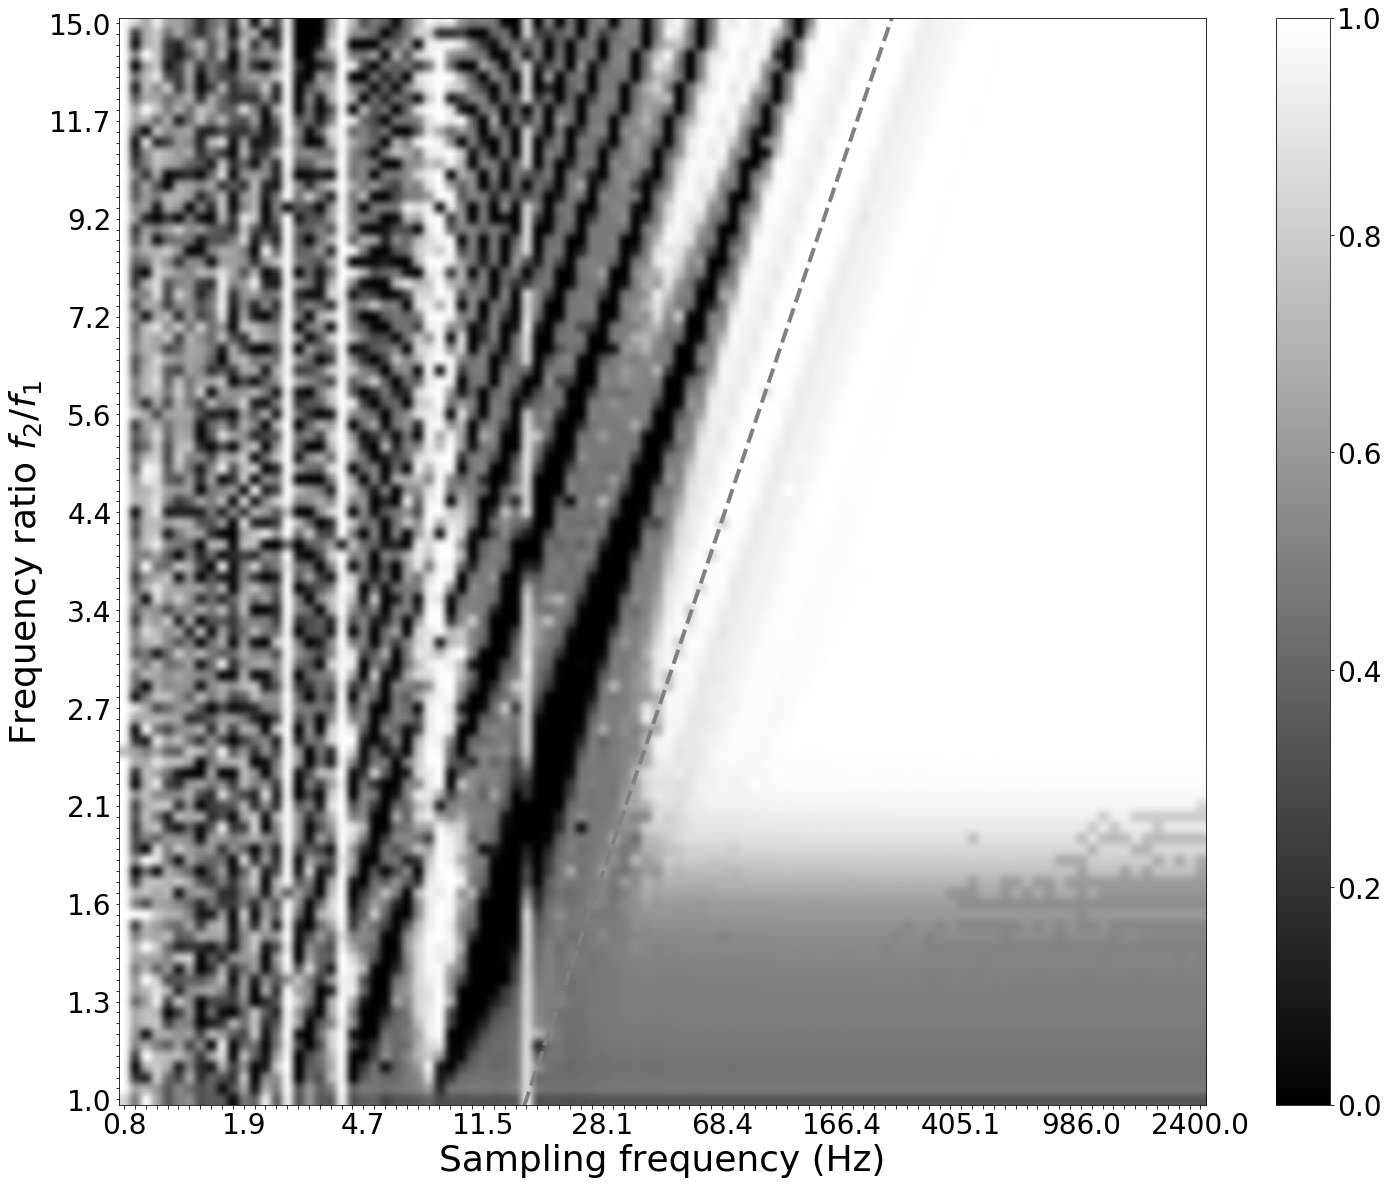

In [197]:
# C_all[n_freq_steps, n_sample_rates, n_lengths, nIMF, nF]

# select which to compare
imf_n = 0   # first IMF, higher frequency
C_n = 1     # second component, higher frequency (note opposite order)

# display image
fig, ax = plt.subplots(figsize=(25,20))
plt.imshow(C_all[:,:,-1,imf_n,C_n]**2, interpolation='hamming', origin='lower', cmap='gray', vmin=0., vmax=1.)

# plot nyquist line
plt.plot(np.arange(0,100), m*np.arange(0,100)+b, linewidth=4, color='gray', linestyle='--')

# labels, ticks, and so on
plt.xlabel('Sampling frequency (Hz)', fontsize=36)
plt.ylabel('Frequency ratio $f_2/f_1$', fontsize=36)
plt.xticks(np.linspace(0,n_sample_rates,n_sample_rates+1), np.round(FS, 1), fontsize=28)
plt.yticks(np.linspace(0,n_freq_steps,n_freq_steps+1), np.round(ratios, 1), fontsize=28)
plt.xlim(-0.5, n_sample_rates-0.5)
plt.ylim(-0.5, n_freq_steps-0.5)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=28)

# show only every nth tick
every_nth_x = 11
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth_x != 0:
        label.set_visible(False)
        
every_nth_y = 9        
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth_y != 0:
        label.set_visible(False)
        
# save and show       
plt.savefig('plots/ch4-1-1_riding_wave_R2.pdf', bbox_inches = "tight")
plt.show()

### Make plot for carrying wave
We look at the $R^2$ between the carrying wave (component 1) and the second IMF. These are the higher frequency components.

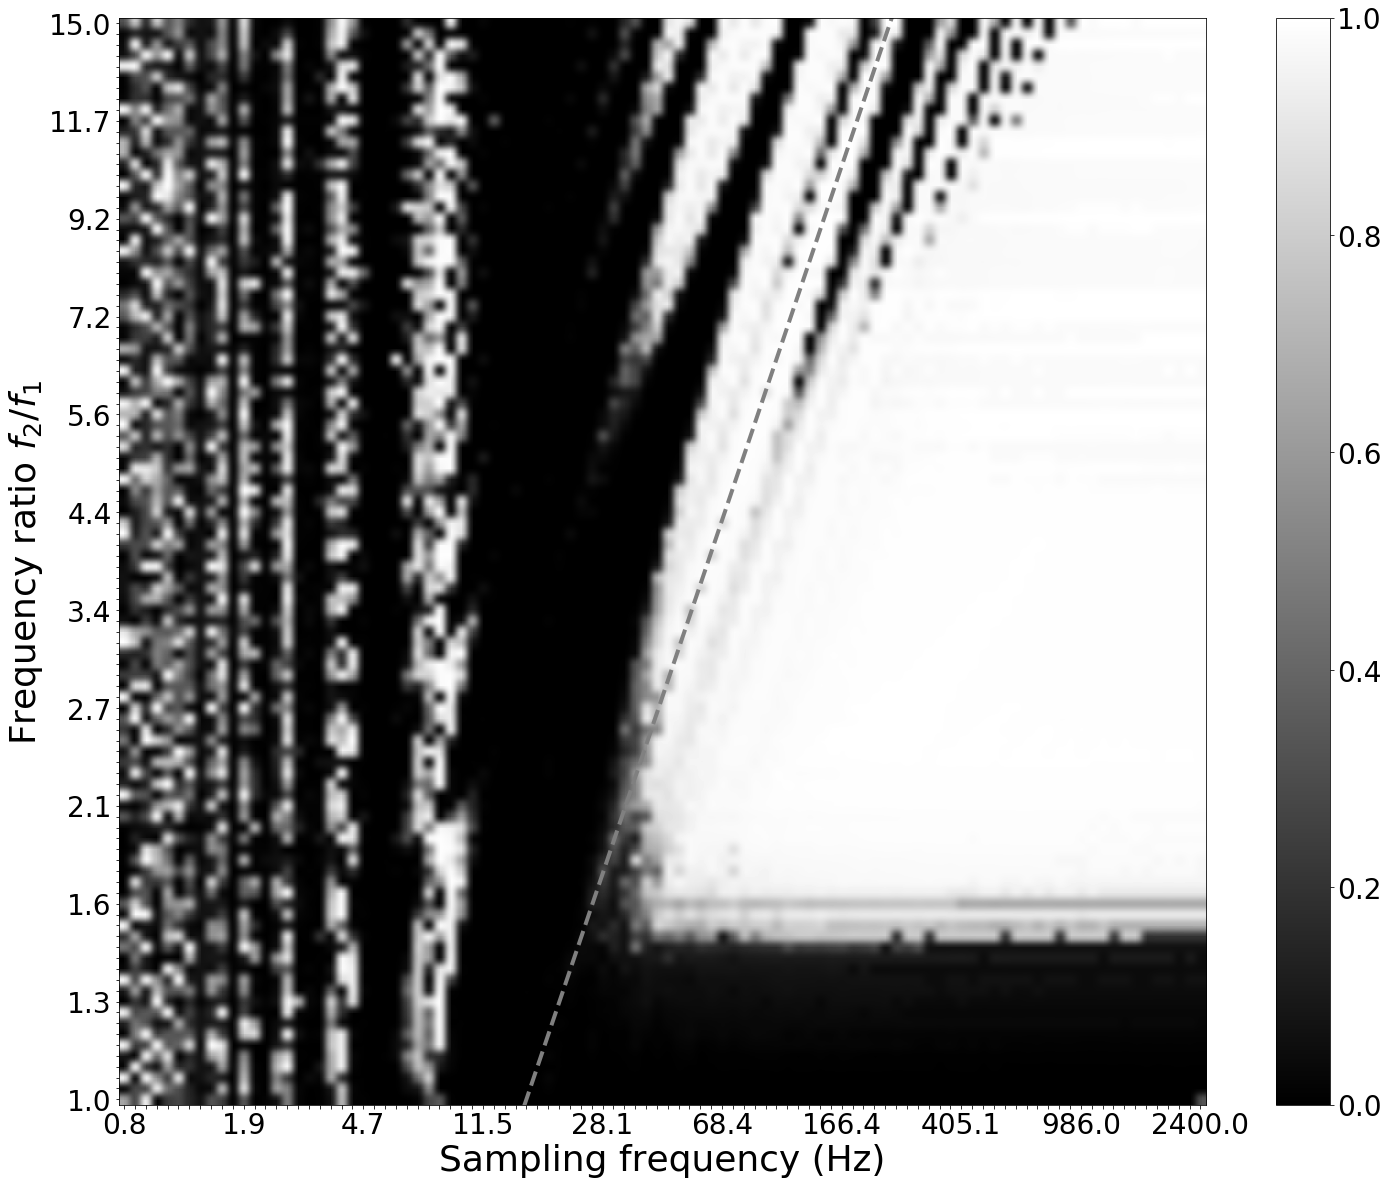

In [198]:
# C_all[n_freq_steps, n_sample_rates, n_lengths, nIMF, nF]

# select which to compare
imf_n = 1   # first IMF, higher frequency
C_n = 0     # second component, higher frequency (note opposite order)

# display image
fig, ax = plt.subplots(figsize=(25,20))
plt.imshow(C_all[:,:,-1,imf_n,C_n]**2, interpolation='hamming', origin='lower', cmap='gray', vmin=0., vmax=1.)

# plot nyquist line
plt.plot(np.arange(0,100), m*np.arange(0,100)+b, linewidth=4, color='gray', linestyle='--')

# labels, ticks, and so on
plt.xlabel('Sampling frequency (Hz)', fontsize=36)
plt.ylabel('Frequency ratio $f_2/f_1$', fontsize=36)
plt.xticks(np.linspace(0,n_sample_rates,n_sample_rates+1), np.round(FS, 1), fontsize=28)
plt.yticks(np.linspace(0,n_freq_steps,n_freq_steps+1), np.round(ratios, 1), fontsize=28)
plt.xlim(-0.5, n_sample_rates-0.5)
plt.ylim(-0.5, n_freq_steps-0.5)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=28)

# show only every nth tick
every_nth_x = 11
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth_x != 0:
        label.set_visible(False)
        
every_nth_y = 9        
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth_y != 0:
        label.set_visible(False)

# save and show       
plt.savefig('plots/ch4-1-2_carrying_wave_R2.pdf', bbox_inches = "tight")
plt.show()

# ---------------------------------------------------------------------------------------
# Extra stuff

Here one can explore the instantaneous frequency and amplitude and some other stuff. This does not appear in the thesis and was not thoroughly checked for errors.

## Instantaneous frequency

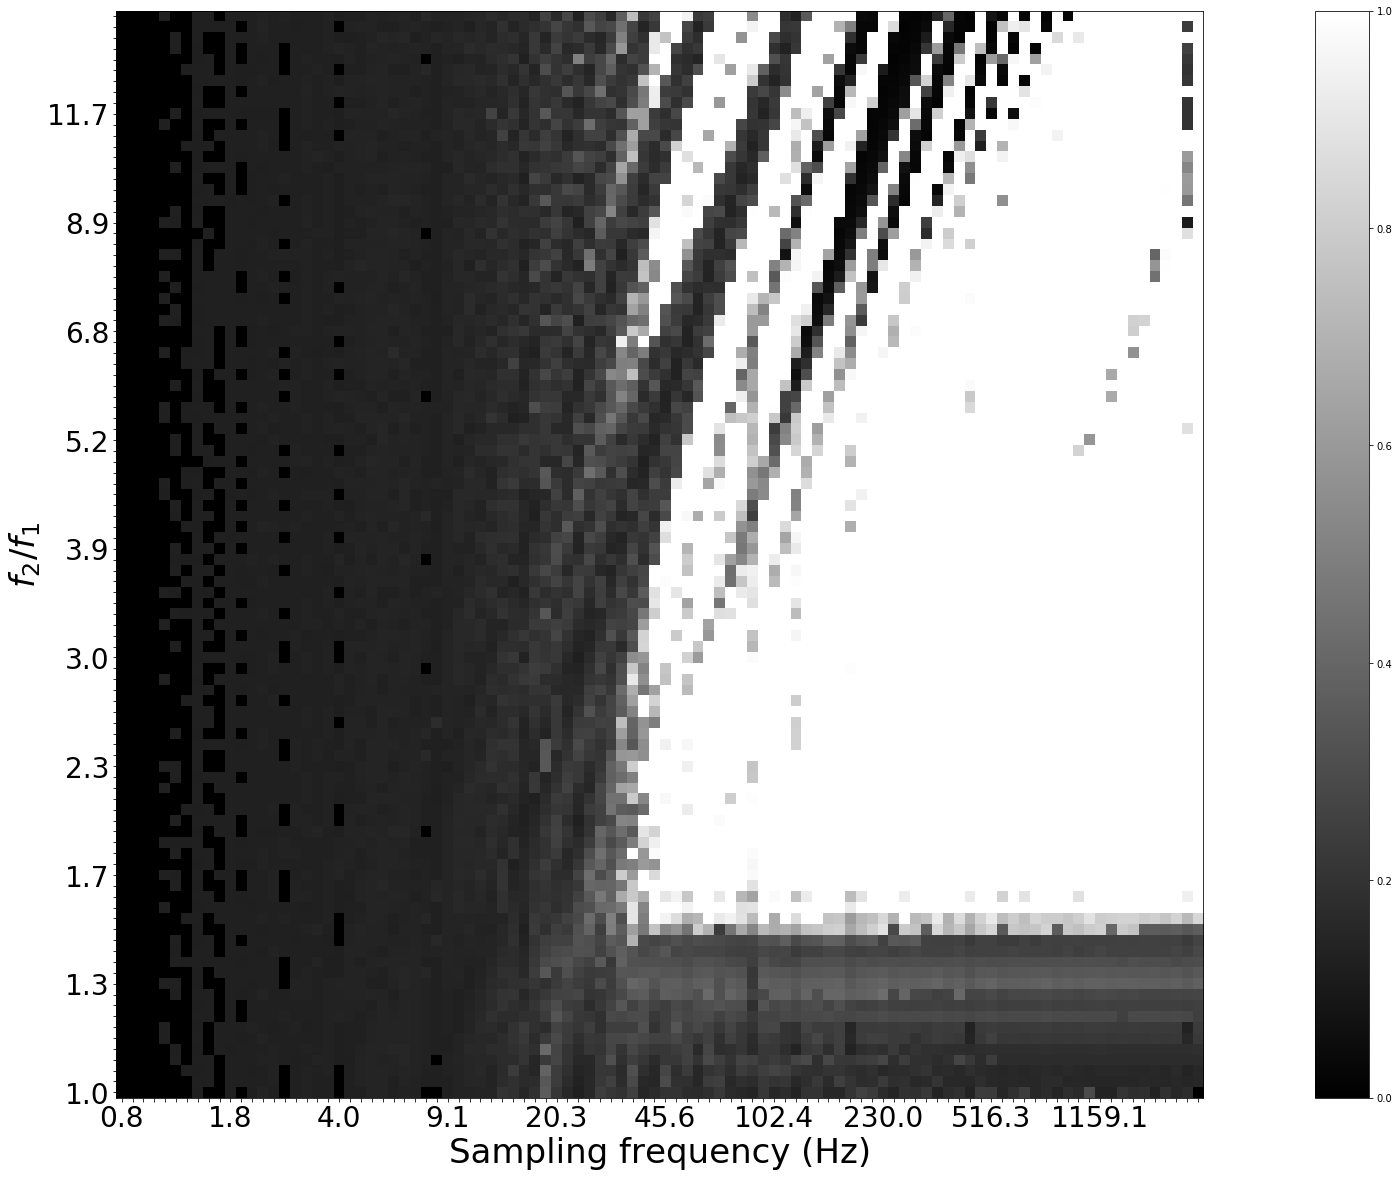

In [234]:
# IF_all[n_freq_steps, n_sample_rates, n_lengths, nF] 

fig, ax = plt.subplots(figsize=(40,20))
plt.imshow(1/IF_all[:,:,-1,1], origin='lower', cmap='gray', vmin=0., vmax=1.)

plt.xlabel('Sampling frequency (Hz)', fontsize=34)
plt.ylabel('$f_2/f_1$', fontsize=34)
plt.xticks(np.linspace(0,n_sample_rates,n_sample_rates+1), np.round(FS, 1), fontsize=28)
plt.yticks(np.linspace(0,n_freq_steps,n_freq_steps+1), np.round(ratios, 1), fontsize=28)
plt.xlim(-0.5, n_sample_rates-0.5)
plt.ylim(-0.5, n_freq_steps-0.5)
plt.colorbar()

# add nyquist
#samp_freq = FS
#res = 1/16 * samp_freq
#plt.plot(samp_freq, res, linestyle='dashed')

every_nth = 10
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
        
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

plt.show()

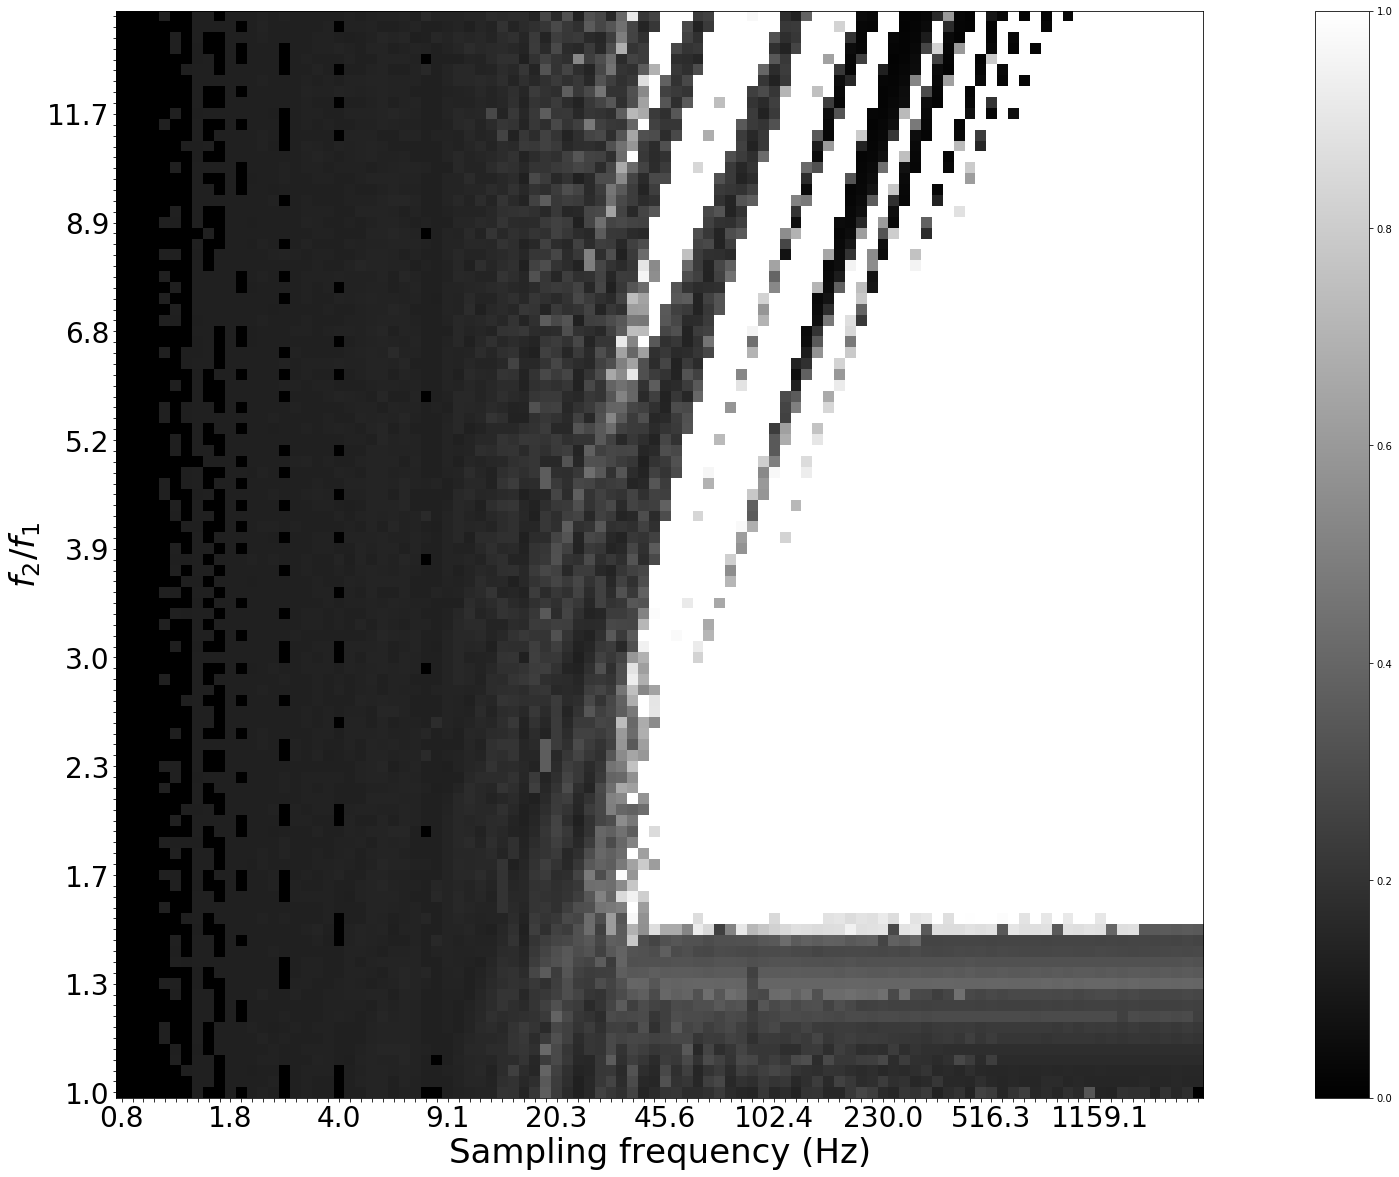

In [235]:
fig, ax = plt.subplots(figsize=(40,20))
plt.imshow(1/IF_nb_all[:,:,-1,1], origin='lower', cmap='gray', vmin=0., vmax=1.)

plt.xlabel('Sampling frequency (Hz)', fontsize=34)
plt.ylabel('$f_2/f_1$', fontsize=34)
plt.xticks(np.linspace(0,n_sample_rates,n_sample_rates+1), np.round(FS, 1), fontsize=28)
plt.yticks(np.linspace(0,n_freq_steps,n_freq_steps+1), np.round(ratios, 1), fontsize=28)
plt.xlim(-0.5, n_sample_rates-0.5)
plt.ylim(-0.5, n_freq_steps-0.5)
plt.colorbar()

# add nyquist
#samp_freq = FS
#res = 1/16 * samp_freq
#plt.plot(samp_freq, res, linestyle='dashed')

every_nth = 10
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
        
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

plt.show()

## Instantaneous amplitude

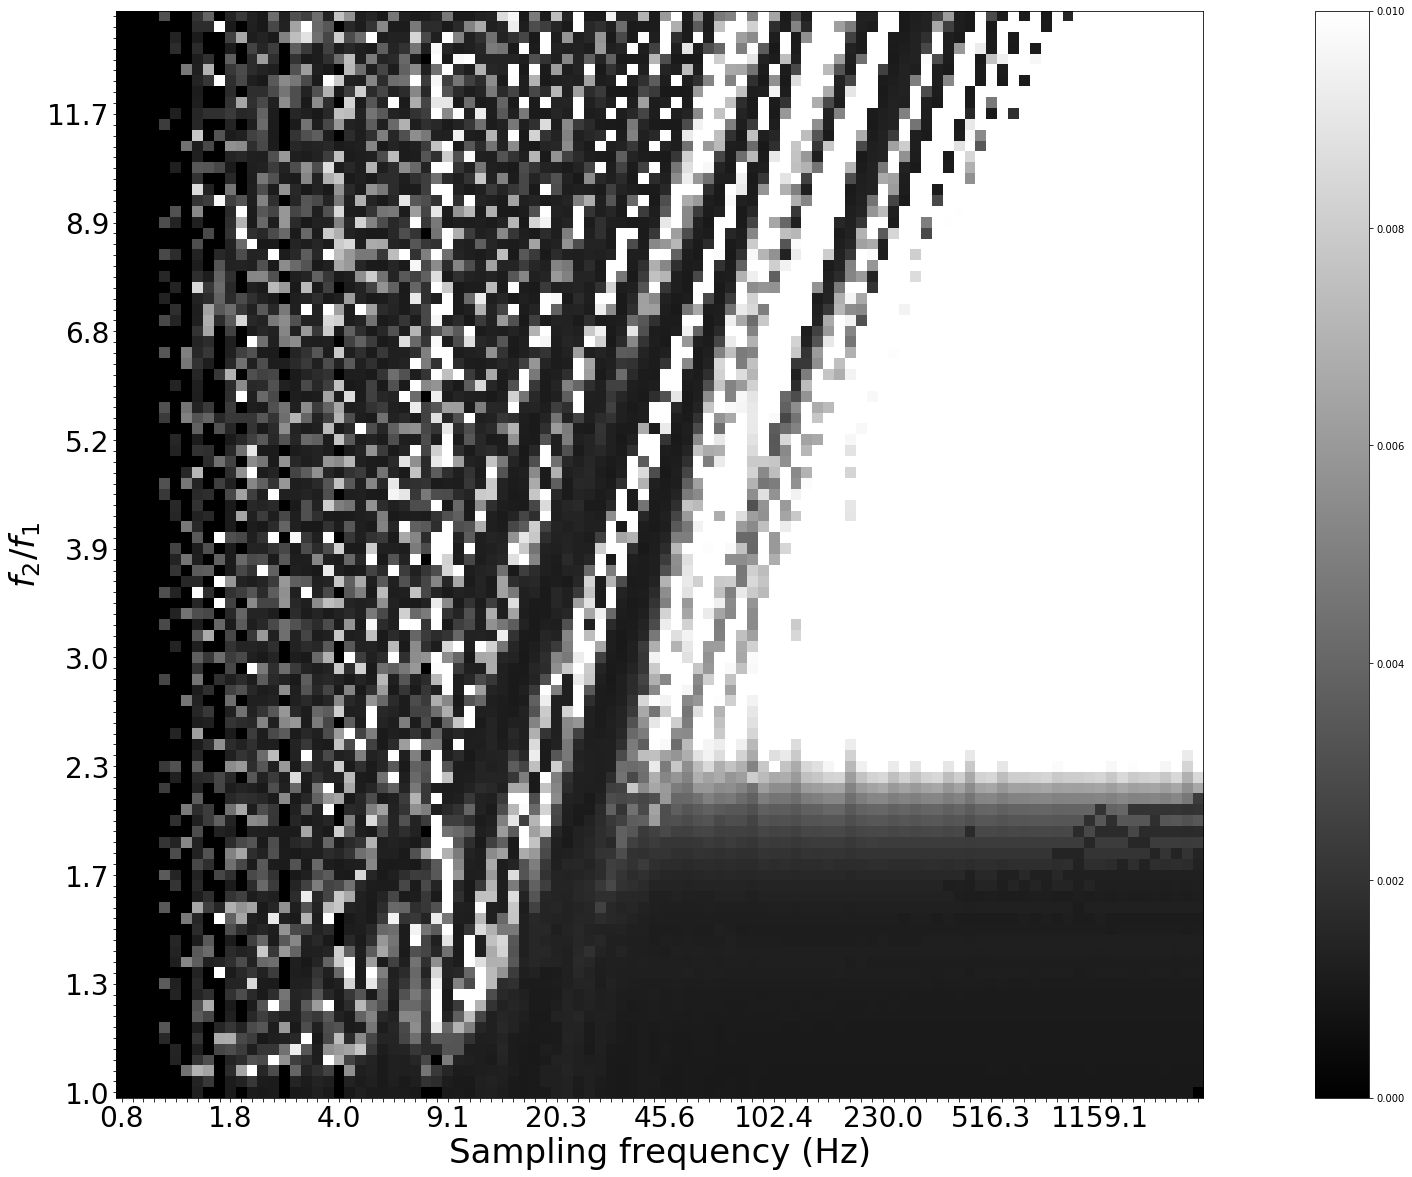

In [239]:
fig, ax = plt.subplots(figsize=(40,20))
plt.imshow(1/IA_all[:,:,-1,1], origin='lower', cmap='gray', vmin=0., vmax=.01)#, vmax=0.1*max_amp)

plt.xlabel('Sampling frequency (Hz)', fontsize=34)
plt.ylabel('$f_2/f_1$', fontsize=34)
plt.xticks(np.linspace(0,n_sample_rates,n_sample_rates+1), np.round(FS, 1), fontsize=28)
plt.yticks(np.linspace(0,n_freq_steps,n_freq_steps+1), np.round(ratios, 1), fontsize=28)
plt.xlim(-0.5, n_sample_rates-0.5)
plt.ylim(-0.5, n_freq_steps-0.5)
plt.colorbar()

# add nyquist
#samp_freq = FS
#res = 1/16 * samp_freq
#plt.plot(samp_freq, res, linestyle='dashed')

every_nth = 10
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
        
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

plt.show()

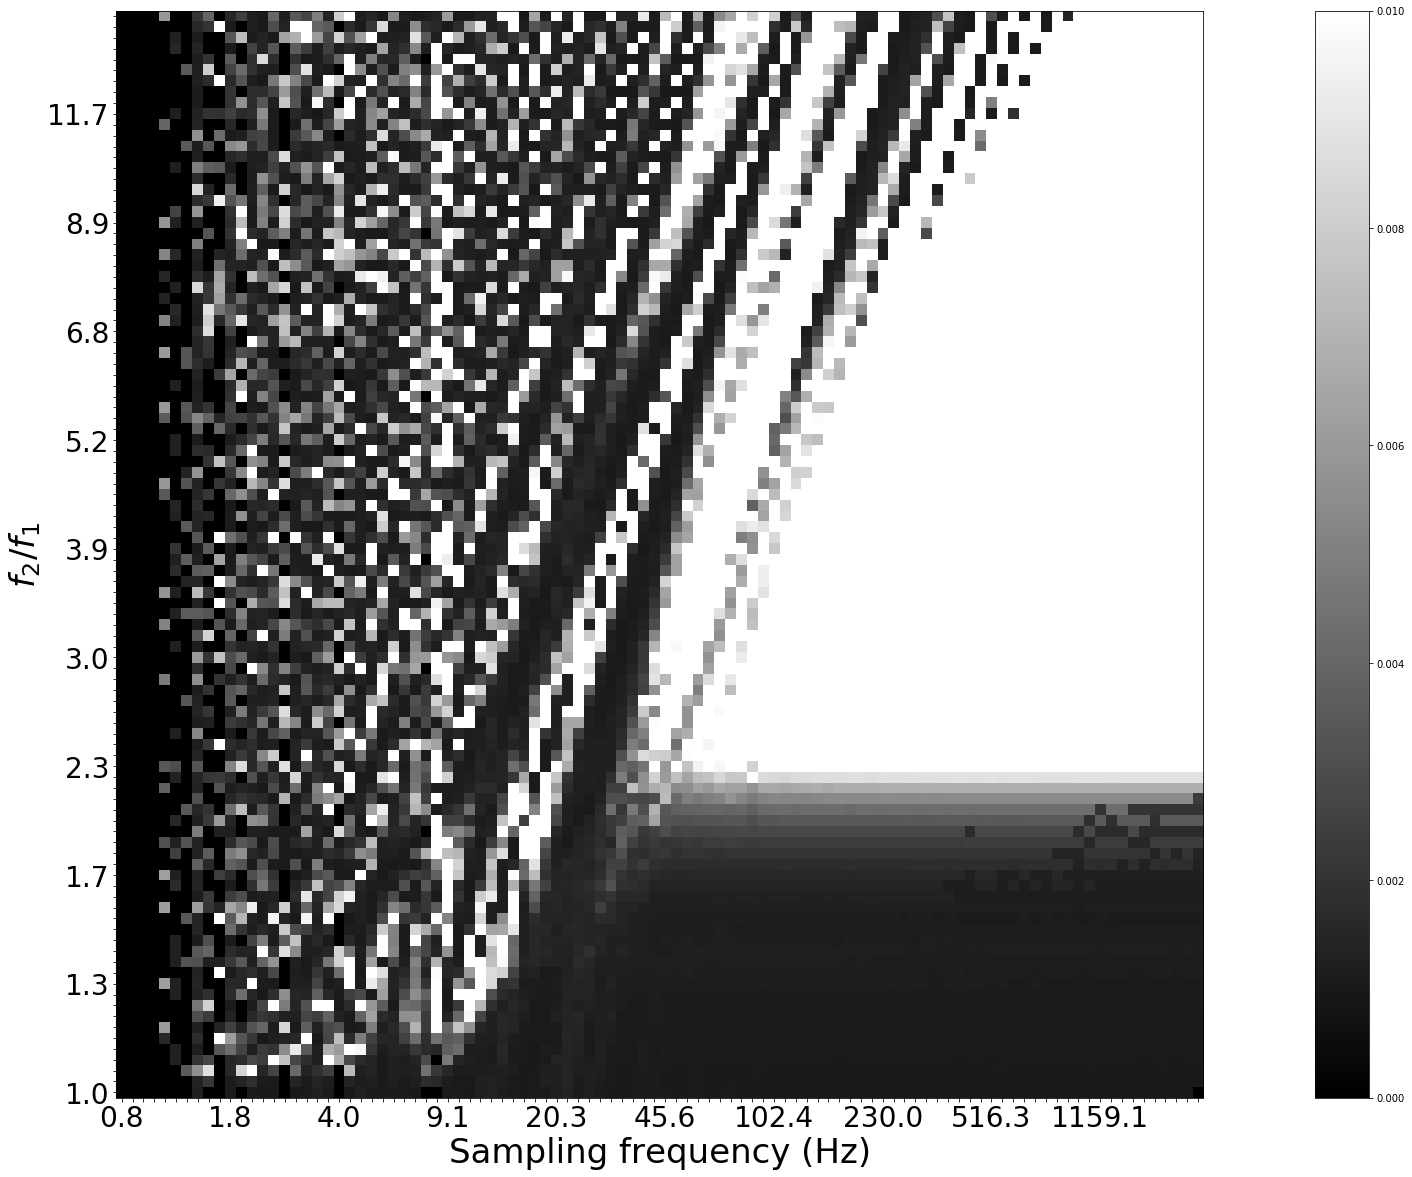

In [241]:
fig, ax = plt.subplots(figsize=(40,20))
plt.imshow(1/IA_nb_all[:,:,-1,1], origin='lower', cmap='gray', vmin=0., vmax=0.01) #*max_amp)

plt.xlabel('Sampling frequency (Hz)', fontsize=34)
plt.ylabel('$f_2/f_1$', fontsize=34)
plt.xticks(np.linspace(0,n_sample_rates,n_sample_rates+1), np.round(FS, 1), fontsize=28)
plt.yticks(np.linspace(0,n_freq_steps,n_freq_steps+1), np.round(ratios, 1), fontsize=28)
plt.xlim(-0.5, n_sample_rates-0.5)
plt.ylim(-0.5, n_freq_steps-0.5)
plt.colorbar()

# add nyquist
#samp_freq = FS
#res = 1/16 * samp_freq
#plt.plot(samp_freq, res, linestyle='dashed')

every_nth = 10
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
        
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

plt.show()

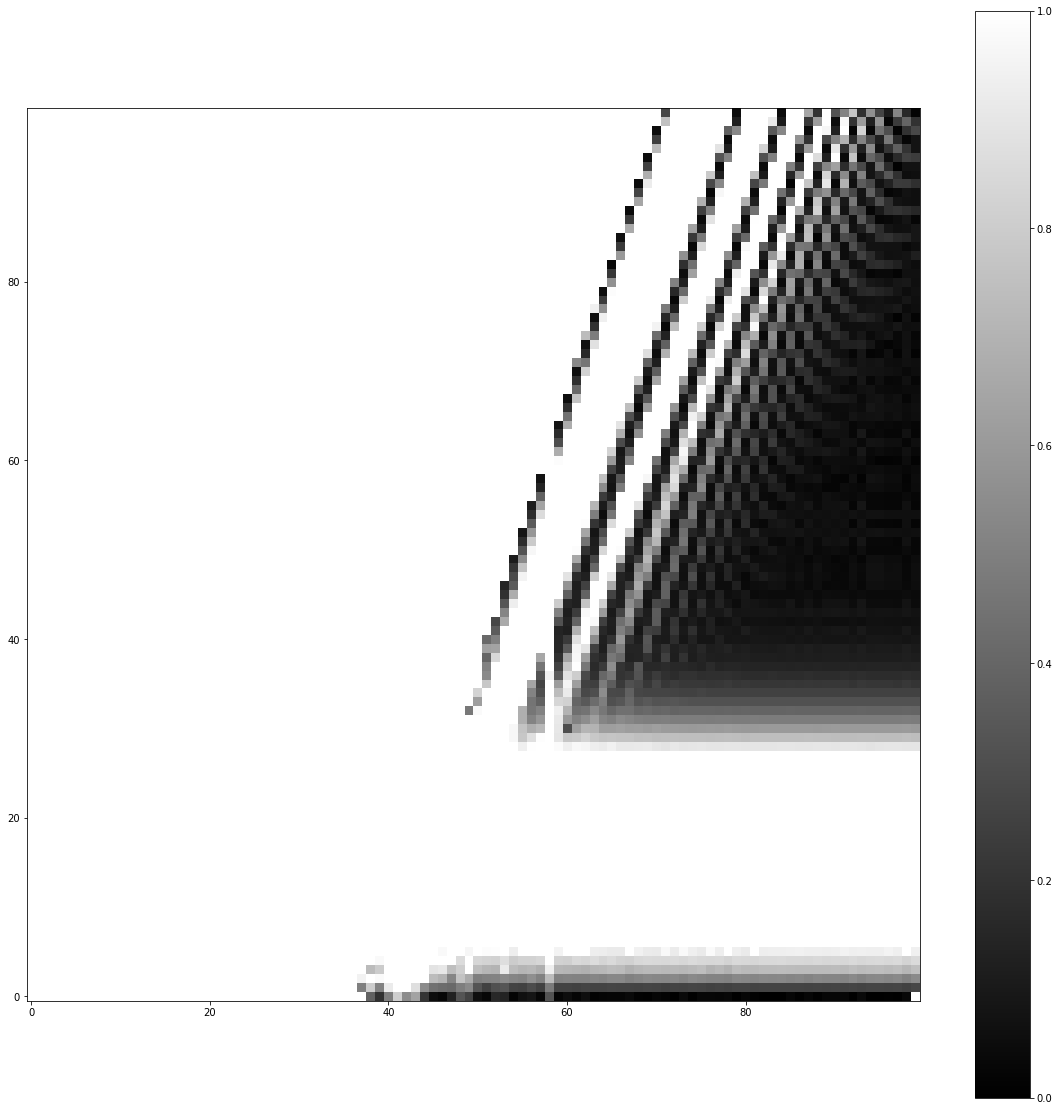

In [71]:
#IF_all[f_i, fs_i, s_i, nF]

plt.figure(figsize=(20,20))
plt.imshow(IF_nb_all[:,:,-1,0], origin='lower', cmap='gray', vmin=0., vmax=1.)
#plt.xlim(0,n_freq_steps)
#plt.ylim(0,n_sample_rates)
plt.colorbar()
plt.show()

In [ ]:
#IF_all[f_i, fs_i, s_i, :]

plt.figure(figsize=(20,20))
plt.imshow(IA_nb_all[:,:,-1,0], origin='lower', cmap='gray', vmin=0., vmax=0.03*max_amp)
plt.colorbar()
plt.show()

In [ ]:
plt.figure(figsize=(10,10))
plt.subplot(211)
plt.imshow(C_all[0,0,:,:])
plt.colorbar()
plt.clim(-0.2, 1.0)
plt.title('Signal Length: ' + str(sig_lengths[0]) + ' seconds')
plt.xlabel('components')
plt.ylabel('imfs')
plt.subplot(212)
plt.imshow(C_all[-1,-1,:,:])
plt.colorbar()
plt.clim(-0.2, 1.0)
plt.title('Signal Length: ' + str(sig_lengths[n_lengths-1]) + ' seconds')
plt.xlabel('components')
plt.ylabel('imfs')
plt.show()

### Compute concentration of correlation matrix on diagonal

In [ ]:
C_all.shape

In [ ]:
diag_conc = np.zeros((n_freq_steps, n_sample_rates, n_lengths))
for k in range(n_freq_steps):
    for j in range(n_sample_rates):
        for i in range(n_lengths):
            sum_diag = np.sum(np.abs(np.diag(np.fliplr(C_all[k,j,i,:,:]))))
            sum_off_diag = np.sum(C_all[k,j,i,:,:]) - sum_diag
            diag_conc[k,j,i] = sum_diag/(sum_diag + sum_off_diag)

In [ ]:
# C_all[n_freq_steps, n_sample_rates, n_lengths, nF, nF]

fig, ax = plt.subplots(figsize=(40,20))
plt.imshow(diag_conc[:,:,-1], origin='lower', cmap='gray', vmin=0., vmax=1.)

plt.xlabel('Sampling frequency (Hz)', fontsize=34)
plt.ylabel('$f_2/f_1$', fontsize=34)
plt.xticks(np.linspace(0,n_sample_rates,n_sample_rates+1), np.round(FS, 1), fontsize=28)
plt.yticks(np.linspace(0,n_freq_steps,n_freq_steps+1), np.round(ratios, 1), fontsize=28)
plt.xlim(-0.5, n_sample_rates-0.5)
plt.ylim(-0.5, n_freq_steps-0.5)
plt.colorbar()

# add nyquist
#samp_freq = FS
#res = 1/16 * samp_freq
#plt.plot(samp_freq, res, linestyle='dashed')

every_nth = 10
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
        
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

plt.show()

### Print median frequencies of IMFs

In [ ]:
np.set_printoptions(suppress=True)
f_m = np.round(np.median(instantaneous_frequency,1),2)
for i in range(len(f_m)):
    print('IMF ' + str(i+1) + ': ' + str(f_m[i]))

### Plot data and IMFs

In [ ]:
plt.figure(figsize=(30,50))
plt.subplot(nIMF+1,1,1)
plt.plot(x, linewidth=3)
plt.xlim(0, fs)
plt.title('Data', fontsize=20)
for ii in range(1,nIMF+1):
    plt.subplot(nIMF+1,1,ii+1)
    plt.plot(imfs[ii-1,:], linewidth=3)
    #plt.plot(C[-ii,:], '--k',linewidth=2)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.title('Intrinsic mode function ' + str(ii) + ': ' + str(f_m[ii-1]) + 'Hz, '
             )#'Actual: ' + str(f[-ii]), fontsize=20)
    plt.xlabel('Time', fontsize=20)
    plt.ylabel('Signal Strength', fontsize=20)
    plt.xlim(0, fs)
plt.show()

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(np.sum(imfs[(f_m > 5.) & (f_m < 12.),:], axis=0))
plt.plot(C[0,:], '--k')
plt.xlim(0, fs)
plt.show()

### Plot instantaneous frequency of IMFs

In [ ]:
plt.figure(figsize=(30,40))
for ii in range(1,nIMF+1):
    plt.subplot(nIMF+1,1,ii+1)
    plt.plot(instantaneous_frequency[ii-1,:], linewidth=3)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.title('Intrinsic mode function ' + str(ii) + ': ' + str(f_m[ii-1]) + 'Hz', fontsize=20)
    plt.xlabel('Time', fontsize=20)
    plt.ylabel('Frequency (Hz)', fontsize=20)
    #plt.xlim(0, fs)
plt.show()

In [ ]:
plt.figure(figsize=(30,40))
for ii in range(1,nIMF+1):
    plt.subplot(nIMF+1,1,ii+1)
    plt.plot(instantaneous_frequency[ii-1,int(nT/20):int(-nT/20)], linewidth=3)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.title('Intrinsic mode function ' + str(ii) + ': ' + str(f_m[ii-1]) + 'Hz', fontsize=20)
    plt.xlabel('Time', fontsize=20)
    plt.ylabel('Frequency (Hz)', fontsize=20)
    #plt.xlim(0, fs)
plt.show()

In [ ]:
np.std(instantaneous_frequency[(f_m > 5.) & (f_m < 12.), :], axis=1)

In [ ]:
np.std(instantaneous_frequency, axis=1)

In [ ]:
np.std(instantaneous_frequency[:, int(nT/20):int(-nT/20)], axis=1)

### Plot data components

In [ ]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
for j in range(nF):
    plt.plot(t, C[j,:], label=str(f[j]))

plt.plot(t, noise)
#plt.axis((0, 0.2, -1.5, 1.5))
plt.legend()
plt.subplot(2,1,2)
plt.plot(t,x)
plt.show()